In [1]:
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32


from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *


/Users/jake/Python/causal_prospective_merge/.conda/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536958/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/jake/Python/causal_prospective_merge/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)
n_rct_before_split = 10**4
n_host = 200
n_mirror = 500
n_cand2 = 500

power_x, power_x_t = 1, 1
causal_param_first_index = 3
outcome_function = lambda X, T, eps: 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * T + 1* X[:,0]*T + -1* X[:,1]*T + eps 
std_true_y = 1 # Standard deviation for the true Y

X0 = np.random.randint(0, 2, size= n_rct_before_split)
X1 = np.random.normal(size=n_rct_before_split)
x_distributions= {0: X0, 1: X1}

p_assigned_to_host = lambda X_1, X_2, T, eps: sigmoid(1 + 2*X_1 - X_2 + T + eps)
p_assigned_to_cand2 = lambda X_1, X_2, T, eps: sigmoid(1 - 2*X_1 + eps)

In [3]:
X_rct, T_rct = generate_rct(n_rct_before_split, x_distributions)
design_data_host, design_data_mirror = generate_host_and_mirror(X_rct, T_rct, p_assigned_to_cand2, n_host, n_mirror, power_x, power_x_t, outcome_function, std_true_y)

pre_X_cand2, pre_T_cand2 = generate_rct(n_rct_before_split, x_distributions)
design_data_cand2 = generate_cand2(pre_X_cand2, pre_T_cand2, p_assigned_to_cand2, n_cand2, \
                                    power_x, power_x_t, outcome_function, std_true_y)

X_mirror, Y_mirror = design_data_mirror.drop(columns=['Y']), design_data_mirror['Y']
X_cand2, Y_cand2 = design_data_cand2.drop(columns=['Y']), design_data_cand2['Y']

### 2. Simulating from prior and plotting
Note: I don't think this is the right way to compare if our estimates are getting better but it will do for now

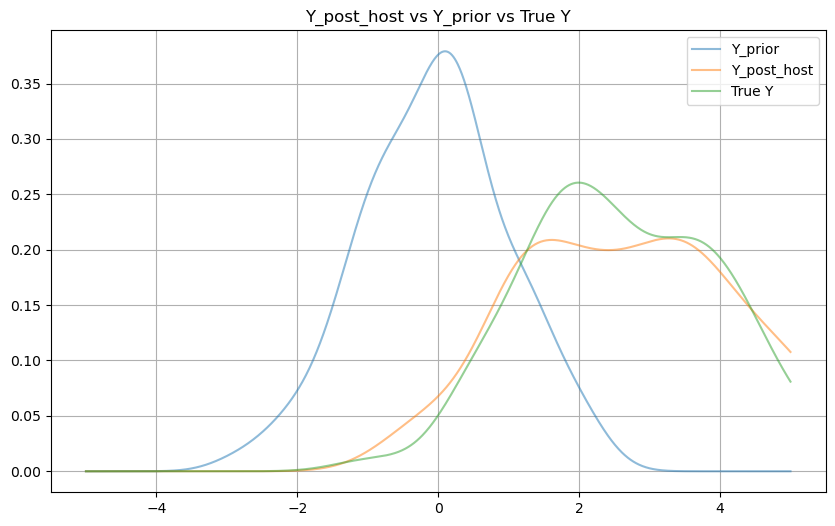

In [4]:
# Initialize prior parameters
post_mean = np.array([0,0 , 0, 0, 0, 0])
beta_0, sigma_0_sq = post_mean, 1
prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq}
bayes_reg = BayesianLinearRegression(prior_hyperparameters)

### Bayesian update through host dataset
X_host, Y_host= design_data_host.drop(columns=['Y']), design_data_host['Y']
post_host_parameters = bayes_reg.fit(X_host, Y_host)

# Generate Y_prior
sigma_prior = 1  # Standard deviation for Y_prior
Y_prior = np.dot(X_host, beta_0) + np.random.normal(0, sigma_prior, len(X_host))

# Generate Y_post_host
beta_post_host_vec = post_host_parameters['posterior_mean'].flatten()  # Extract posterior mean
cov_matrix_post_host = post_host_parameters['posterior_cov_matrix']
Y_post_host = np.dot(X_host, beta_post_host_vec) + np.random.normal(0, 1, len(X_host))  # Assuming standard deviation for Y_post_host is 1

plot_densities(Y_prior, Y_post_host, design_data_host['Y'], 
                names = ['Y_prior', 'Y_post_host', 'True Y'], 
                title = 'Y_post_host vs Y_prior vs True Y')


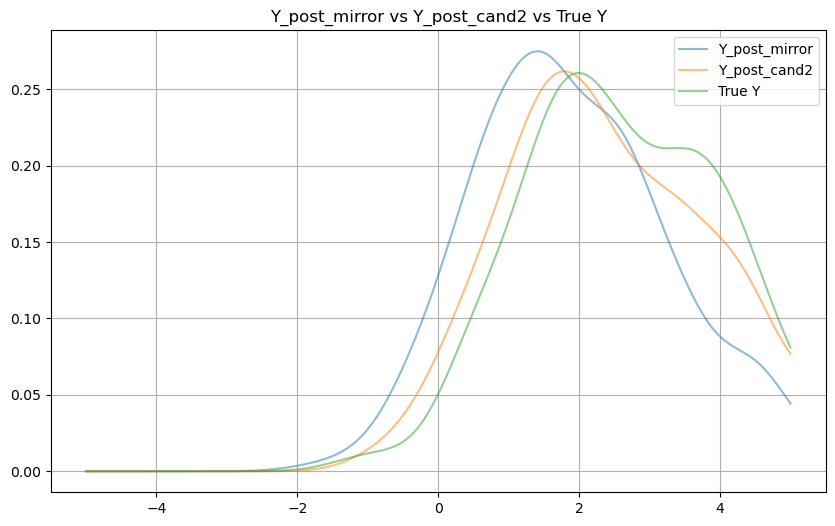

In [5]:
### Bayesian update through candidate datasets
sigma_cand = 1
prior_hyperparameters_cand = {'beta_0': beta_post_host_vec, 'sigma_0_sq': sigma_cand}

## With candidate = mirror dataset
bayes_reg_mirror = BayesianLinearRegression(prior_hyperparameters_cand)
X_mirror, Y_mirror = design_data_mirror.drop(columns=['Y']), design_data_mirror['Y']
post_mirror_parameters = bayes_reg_mirror.fit(X_mirror, Y_mirror)

# Generate Y_post_mirror
post_mirror_mean = post_mirror_parameters['posterior_mean'].flatten()  # Extract posterior mean
Y_post_mirror = np.dot(X_mirror, post_mirror_mean) + np.random.normal(0, 1, len(X_mirror))  # Assuming standard deviation for Y_post_host is 1

## With candidate = cand2 dataset
bayes_reg_cand2 = BayesianLinearRegression(prior_hyperparameters_cand)
X_cand2, Y_cand2 = design_data_cand2.drop(columns=['Y']), design_data_cand2['Y']
post_cand2_parameters = bayes_reg_cand2.fit(X_cand2, Y_cand2)

# Generate Y_post_cand2
post_cand2_mean = post_cand2_parameters['posterior_mean'].flatten()  # Extract posterior mean
Y_post_cand2 = np.dot(X_cand2, post_cand2_mean) + np.random.normal(0, 1, len(X_cand2))  # Assuming standard deviation for Y_post_host is 1

plot_densities(Y_post_mirror, Y_post_cand2, design_data_host['Y'],
                names = ['Y_post_mirror', 'Y_post_cand2', 'True Y'], 
                title = 'Y_post_mirror vs Y_post_cand2 vs True Y')


In [6]:
#Number of samples used to estimate outer expectation
n_samples_for_expectation = 20
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))
# Incorporating sqrt constraint into MCMC samples
n_mcmc = (n_samples_for_expectation * (m_samples_for_expectation+1)) 

warmup_steps = 10
max_tree_depth = 7
sigma_rand_error = 1

X_torch = torch.tensor(X_host.values)
Y_torch = torch.tensor(Y_host.values)

## Bayesian update using the host dataset
mcmc_host = MCMC_Bayesian_update(X_torch =X_torch, Y_torch = Y_torch, model =model_normal,
            mu_0= beta_0, sigma_prior = sigma_prior, sigma_rand_error = sigma_rand_error,
            sigma_rand_error_fixed = True,n_mcmc = n_mcmc, warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
mcmc_host.summary()

beta_post_host = pd.DataFrame(mcmc_host.get_samples())

#Shuffling to remove any dependence between adjacent samples
beta_post_host = beta_post_host.sample(frac = 1)

beta_post_host.head()
# We delete the column with the std
beta_post_host_without_std = beta_post_host.iloc[:, :-1] 

Warmup:   0%|          | 0/130 [00:00, ?it/s]

Sample: 100%|██████████| 130/130 [00:01, 112.54it/s, step size=5.21e-02, acc. prob=0.914]

Inference ran for 0.02 minutes

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0      2.05      0.11      2.04      1.90      2.24     40.85      0.99
    beta_1     -0.70      0.21     -0.71     -1.01     -0.33     34.04      1.02
    beta_2      0.07      0.12      0.08     -0.09      0.31    101.53      1.00
    beta_3      1.84      0.14      1.84      1.62      2.05     76.77      0.99
    beta_4     -1.29      0.26     -1.29     -1.69     -0.86     41.75      1.00
    beta_5      0.14      0.16      0.14     -0.17      0.37     85.62      0.99

Number of divergences: 0


In [7]:
beta_post_host.describe()

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,2.050292,-0.700250,0.072116,1.844741,-1.288742,0.138701
std,0.108200,0.211496,0.123071,0.141113,0.261486,0.164427
min,1.783481,-1.158025,-0.221821,1.484427,-1.810186,-0.237488
25%,1.972319,-0.852652,-0.013006,1.741459,-1.489550,0.020763
50%,2.046231,-0.712961,0.075653,1.841773,-1.293713,0.135642
75%,2.116776,-0.572929,0.156700,1.953227,-1.098507,0.238095
max,2.318285,-0.172516,0.359133,2.164302,-0.613308,0.606119


In [8]:
beta_post_host.cov()

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5
beta_0,0.011707,-0.012684,0.000843,-0.009195,0.010497,0.000072
beta_1,-0.012684,0.044731,-0.008604,0.010583,-0.037814,0.008795
beta_2,0.000843,-0.008604,0.015146,0.001083,0.009446,-0.016562
beta_3,-0.009195,0.010583,0.001083,0.019913,-0.021406,-0.003324
beta_4,0.010497,-0.037814,0.009446,-0.021406,0.068375,-0.009094
beta_5,0.000072,0.008795,-0.016562,-0.003324,-0.009094,0.027036


In [9]:
pd.DataFrame(beta_post_host.cov().values - cov_matrix_post_host)

,0,1,2,3,4,5
0,-0.016320,0.015282,0.000326,0.018832,-0.017469,0.000588
1,0.015282,-0.068758,-0.010774,-0.017383,0.075674,0.010964
2,0.000326,-0.010774,-0.007556,0.001599,0.011616,0.006141
3,0.018832,-0.017383,0.001599,-0.034979,0.033425,-0.003853
4,-0.017469,0.075674,0.011616,0.033425,-0.126513,-0.011141
5,0.000588,0.010964,0.006141,-0.003853,-0.011141,-0.013357


### 3. Calculating EIG observational

For the mirror dataset

First, we calculate EIG using samples by getting the model predictions and putting them in the correct form

In [10]:
X_mirror_arr = X_mirror.values
Y_pred_mirror = predict_with_all_sampled_linear(beta_post_host, X_mirror_arr)

pred_list_mirror = predictions_in_EIG_obs_form(Y_pred_mirror,n_samples_for_expectation,m_samples_for_expectation)

In [11]:
compute_EIG_obs_from_samples(pred_list_mirror, sigma_rand_error)

5.058336636994795

Now to calculate for the causal

In [12]:
sample_func = return_causal_samp_func_linear(X=X_torch,Y=Y_torch,causal_param_first_index=3,mu_0=beta_0,sigma_prior = sigma_prior,
                                            sigma_rand_error = sigma_rand_error,sigma_rand_error_fixed = True,warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
pred_func = lambda beta: beta @ (X_mirror).T

In [13]:
# pred_in_causal_form = predictions_in_EIG_causal_form(pred_func, theta_samples=beta_post_host.values[:40], theta_sampling_function=sample_func, n_non_causal_expectation=100, causal_param_first_index=3)

In [14]:
# compute_EIG_causal_from_samples(pred_list_mirror,pred_in_causal_form, sigma_rand_error)

Now, trying to calculate in closed form

In [15]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host,sigma_rand_error)

5.459296155108518

In [16]:
compute_EIG_causal_closed_form(X_mirror_arr, cov_matrix_post_host,sigma_rand_error, 3)

2.0145529150136143

For the cand2 dataset

In [17]:
X_cand2_arr = X_cand2.values
Y_pred_cand2 = predict_with_all_sampled_linear(beta_post_host, X_cand2_arr)

pred_list_cand2 = predictions_in_EIG_obs_form(Y_pred_cand2, n_samples_for_expectation, m_samples_for_expectation)

In [18]:
compute_EIG_obs_from_samples(pred_list_cand2, sigma_rand_error)

6.135883769658335

Now, trying to calculate in closed form

In [19]:
compute_EIG_obs_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error)

5.366968305823764

In [20]:
compute_EIG_causal_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error, 3)

1.935658070552135

In [21]:
from scipy.stats import multivariate_normal

In [22]:
mvn = multivariate_normal(mean=beta_post_host_vec, cov=cov_matrix_post_host)

In [23]:
n_samples_for_expectation = 1000
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))

In [24]:
beta = mvn.rvs(n_samples_for_expectation*(m_samples_for_expectation+1))

In [25]:
beta.shape

(33000, 6)

In [26]:
sigma_rand_error = 1

In [27]:
y_pred_vec = predict_with_all_sampled_linear(pd.DataFrame(beta), X_mirror_arr)

In [28]:
y_pred_form = predictions_in_EIG_obs_form(y_pred_vec, n_samples_for_expectation, m_samples_for_expectation)

In [29]:
compute_EIG_obs_from_samples(y_pred_form, sigma_rand_error)

10.03388738751687

In [30]:
calc_posterior_predictive_entropy(y_pred_form, sigma_rand_error)

719.8557791791966

In [31]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host,sigma_rand_error)

5.459296155108518

In [34]:
n_e = len(y_pred_form[0][0])
X = X_mirror_arr
sign,log_det_term = np.linalg.slogdet( X @ ((cov_matrix_post_host) @ X.T) + (sigma_rand_error**2) * np.eye(n_e) )
1/2*log_det_term + n_e/2 * (1 + np.log(2 * np.pi))

714.9285627574449

In [35]:
beta_repeat = np.tile(beta_post_host_vec,(33000,1))

In [36]:
y_pred_vec_repeat = predict_with_all_sampled_linear(pd.DataFrame(beta_repeat), X_mirror_arr)

In [37]:
y_pred_vec.shape

(33000, 500)

In [38]:
y_pred_vec_repeat.shape

(33000, 500)

In [39]:
y_pred_form_repeat = predictions_in_EIG_obs_form(y_pred_vec_repeat, n_samples_for_expectation, m_samples_for_expectation)

In [40]:
cov_matrix_post_host_zero = np.zeros_like(cov_matrix_post_host)

In [41]:
sigma_repeat = 0.0001

In [42]:
compute_EIG_obs_from_samples(y_pred_form_repeat,  sigma_repeat)

-0.026771124688821146

In [43]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host_zero,sigma_repeat)

-9.094947017729282e-12

In [44]:
n_e = len(y_pred_form_repeat[0][0])
X = X_mirror_arr
sign,log_det_term = np.linalg.slogdet( X @ ((cov_matrix_post_host_zero) @ X.T) + (sigma_repeat**2) * np.eye(n_e) )
1/2*log_det_term + n_e/2 * (1 + np.log(2 * np.pi))

-3895.700919385764

In [45]:
calc_posterior_predictive_entropy(y_pred_form_repeat, sigma_repeat)

-3896.192395575803

In [46]:
cov_matrix_post_host_id = 1*np.eye(6)
mvn_id = multivariate_normal(mean=beta_post_host_vec, cov=cov_matrix_post_host_id)
n_samples_for_expectation = 500
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))
beta_id = mvn_id.rvs(n_samples_for_expectation*(m_samples_for_expectation+1))

In [47]:
sigma_rand_error = 1

In [48]:
y_pred_vec_id = predict_with_all_sampled_linear(pd.DataFrame(beta_id), X_mirror_arr)
y_pred_form_id = predictions_in_EIG_obs_form(y_pred_vec_id, n_samples_for_expectation, m_samples_for_expectation)

In [49]:
compute_EIG_obs_from_samples(y_pred_form_id, sigma_rand_error)

343.8243464314478

In [50]:
pd.DataFrame(beta_id).cov()

,0,1,2,3,4,5
0,1.004736,-0.008630,0.006549,-0.002135,0.000821,-0.007160
1,-0.008630,0.983862,-0.009540,-0.001027,-0.008788,0.011406
2,0.006549,-0.009540,1.008907,0.005135,-0.014314,-0.001423
3,-0.002135,-0.001027,0.005135,0.971631,-0.007114,-0.006365
4,0.000821,-0.008788,-0.014314,-0.007114,0.995321,-0.021237
5,-0.007160,0.011406,-0.001423,-0.006365,-0.021237,1.011163


In [51]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host_id,sigma_rand_error)

15.040968899832732

In [52]:
calc_posterior_predictive_entropy(y_pred_form_id, sigma_rand_error)

1053.9226983992012

In [53]:
n_e = len(y_pred_form_repeat[0][0])
X = X_mirror_arr
sign,log_det_term = np.linalg.slogdet( X @ ((cov_matrix_post_host_id) @ X.T) + (sigma_rand_error**2) * np.eye(n_e) )
1/2*log_det_term + n_e/2 * (1 + np.log(2 * np.pi))

724.510235502169

In [54]:
sign, log_det = np.linalg.slogdet(X @ ((10*cov_matrix_post_host_id) @ X.T))
log_det

-14769.140000624991

In [55]:
np.linalg.det(X @ ((cov_matrix_post_host_id) @ X.T))

-0.0